In [794]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import random
warnings.simplefilter("ignore")

In [795]:
accept = pd.read_csv("14_accept.csv")

In [796]:
accept['target'].value_counts()

0    31857
1      697
Name: target, dtype: int64

In [797]:
print('Доля 1 в выборке accept =', 697 / accept['target'].shape[0])

Доля 1 в выборке accept = 0.021410579345088162


In [798]:
accept.dtypes

target                         int64
INCOME_TYPE                   object
EDUCATION_                    object
CUSTOMER_CATEGORY_            object
income                       float64
DEPENDANT_NUMBER             float64
IS_EMPL                        int64
COUNT_ACTIVE_CREDIT_NO_CC    float64
CNT_MNTH_FROM_LAST_PMNT      float64
age                          float64
experience                   float64
inquiry_14_day               float64
inquiry_21_day               float64
count_mnth_act_passport      float64
UID                            int64
dtype: object

In [799]:
num_cols = accept.columns[accept.dtypes != object].tolist()
cat_cols = accept.columns[accept.dtypes == object].tolist()
num_cols.remove('target')
num_cols.remove('IS_EMPL')
cat_cols.append('IS_EMPL')

In [800]:
accept[num_cols].describe()

,income,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
count,3.187800e+04,32515.000000,24256.000000,22498.000000,32554.000000,32509.000000,23449.000000,23449.000000,32554.000000,32554.000000
mean,6.088754e+04,0.007566,0.672164,19.936247,36.492725,4.925367,0.358523,0.423387,7.227920,70298.984979
std,6.894709e+04,0.105827,0.835934,139.118705,8.223319,5.364458,0.608807,0.685381,3.348460,40637.873974
min,0.000000e+00,0.000000,0.000000,-66.559028,25.000299,-157.184939,0.000000,0.000000,-0.005464,10.000000
25%,2.700000e+04,0.000000,0.000000,0.529822,29.590927,1.232001,0.000000,0.000000,4.949847,35223.750000
50%,4.160700e+04,0.000000,0.000000,0.926131,34.761213,3.280747,0.000000,0.000000,7.761644,70207.000000
75%,7.000000e+04,0.000000,1.000000,3.506166,42.339402,6.547945,1.000000,1.000000,9.917808,105469.000000
max,2.000095e+06,4.000000,8.000000,1365.276703,62.320548,100.355191,6.000000,8.000000,15.805479,140904.000000


In [801]:
accept['experience'] = accept[['experience']].apply(lambda x: x[0] if x[0] > 0 else np.NaN, axis=1)
accept['count_mnth_act_passport'] = accept[['count_mnth_act_passport']].apply(lambda x: x[0] if x[0] >= 0 else np.NaN, axis=1)
accept['CNT_MNTH_FROM_LAST_PMNT'] = accept[['CNT_MNTH_FROM_LAST_PMNT']].apply(lambda x: x[0] if x[0] >= 0 else np.NaN, axis=1)

#### Доля пропущенных значений в числовых переменных

In [802]:
accept[num_cols].isna().sum() / accept.shape[0]

income                       0.020765
DEPENDANT_NUMBER             0.001198
COUNT_ACTIVE_CREDIT_NO_CC    0.254900
CNT_MNTH_FROM_LAST_PMNT      0.324261
age                          0.000000
experience                   0.001444
inquiry_14_day               0.279689
inquiry_21_day               0.279689
count_mnth_act_passport      0.000061
UID                          0.000000
dtype: float64

#### Среднее значение числовых переменных

In [803]:
np.mean(accept[num_cols])

income                       60887.538647
DEPENDANT_NUMBER                 0.007566
COUNT_ACTIVE_CREDIT_NO_CC        0.672164
CNT_MNTH_FROM_LAST_PMNT         20.409318
age                             36.492725
experience                       4.930647
inquiry_14_day                   0.358523
inquiry_21_day                   0.423387
count_mnth_act_passport          7.228365
UID                          70298.984979
dtype: float64

#### Медианное значение числовых переменных

In [804]:
accept[num_cols].quantile(.5)

income                       41607.000000
DEPENDANT_NUMBER                 0.000000
COUNT_ACTIVE_CREDIT_NO_CC        0.000000
CNT_MNTH_FROM_LAST_PMNT          0.952498
age                             34.761213
experience                       3.282192
inquiry_14_day                   0.000000
inquiry_21_day                   0.000000
count_mnth_act_passport          7.761644
UID                          70207.000000
Name: 0.5, dtype: float64

#### Среднеквадратичное отклонение числовых переменных

In [805]:
np.square(np.std(accept[num_cols]))

income                       4.753552e+09
DEPENDANT_NUMBER             1.119910e-02
COUNT_ACTIVE_CREDIT_NO_CC    6.987568e-01
CNT_MNTH_FROM_LAST_PMNT      1.978267e+04
age                          6.762090e+01
experience                   2.796704e+01
inquiry_14_day               3.706298e-01
inquiry_21_day               4.697264e-01
count_mnth_act_passport      1.120932e+01
UID                          1.651386e+09
dtype: float64

In [806]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()

    
    return dset, iv

#### Функция взята из семинарского ноутбука. Она позволяет создавать WoE переменные и быстро подсчитывать IV.

In [807]:
# Разбиваем числовые данные на бины для дальнейшей работы
for col in num_cols:
    accept[col + '_bin'] = pd.qcut(accept[col], 8, duplicates='drop')
    accept[col + '_bin'] = accept[col + '_bin'].cat.add_categories("0-0").fillna("0-0")

#### Information Value числовых переменных

In [808]:
for col in num_cols:
    df, iv = calculate_woe_iv(accept, col + '_bin', 'target')
    print('Information Value  ', col, '     ', iv)

Information Value   income       0.11667338716393472
Information Value   DEPENDANT_NUMBER       0.0032218632682540225
Information Value   COUNT_ACTIVE_CREDIT_NO_CC       0.0955053003444348
Information Value   CNT_MNTH_FROM_LAST_PMNT       0.10962393941375867
Information Value   age       0.016072172078180652
Information Value   experience       0.48588802895106453
Information Value   inquiry_14_day       0.09468058456218917
Information Value   inquiry_21_day       0.13834612649132647
Information Value   count_mnth_act_passport       0.04462532026455026
Information Value   UID       0.03896065726267739


#### Доля пропущенных значений в категориальных переменных

In [809]:
accept[cat_cols].isna().sum() / accept.shape[0]

INCOME_TYPE           0.000000
EDUCATION_            0.000000
CUSTOMER_CATEGORY_    0.596056
IS_EMPL               0.000000
dtype: float64

Обращает на себя внимание кол-во пропусков в фиче CUSTOMER_CATEGORY_, но вероятно это просто клиенты, не входящие не в одну из категорий

In [810]:
accept['IS_EMPL'].replace(0, 'No', inplace=True)
accept['IS_EMPL'].replace(1, 'Yes', inplace=True)

#### Уникальные значения, мода и её частота

In [811]:
accept[cat_cols].describe()

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL
count,32554,32554,13150,32554
unique,2,4,2,2
top,OTHER,elementary,Corporate,No
freq,21943,21328,12732,19753


#### Information Value категориальных переменных

In [812]:
for col in cat_cols:
    df, iv = calculate_woe_iv(accept, col, 'target')
    print('Information Value  ', col, '     ', iv)

Information Value   INCOME_TYPE       0.01750849232852488
Information Value   EDUCATION_       0.04508276400833667
Information Value   CUSTOMER_CATEGORY_       0.0
Information Value   IS_EMPL       0.7186495608351685


In [813]:
#я не смог выявить ошибку в коде, хотя она явно есть, поэтому посчитал для фичи CUSTOMER_CATEGORY_ WoE и IV вручную
accept['CUSTOMER_CATEGORY_'].fillna('0-0', inplace=True)

all_good = accept[(accept['target'] < 0.5)].shape[0]
all_bad = accept[(accept['target'] > 0.5)].shape[0]

good = accept[(accept['CUSTOMER_CATEGORY_'] == 'Corporate') & (accept['target'] < 0.5)].shape[0]
bad = accept[(accept['CUSTOMER_CATEGORY_'] == 'Corporate') & (accept['target'] > 0.5)].shape[0]
WoE_Corporate = np.log((bad / all_bad) / (good / all_good))

good_1 = accept[(accept['CUSTOMER_CATEGORY_'] == 'VIP') & (accept['target'] < 0.5)].shape[0]
bad_1 = accept[(accept['CUSTOMER_CATEGORY_'] == 'VIP') & (accept['target'] > 0.5)].shape[0]
WoE_VIP = np.log((bad_1 / all_bad) / (good_1 / all_good))

good_2 = accept[(accept['CUSTOMER_CATEGORY_'] == '0-0') & (accept['target'] < 0.5)].shape[0]
bad_2 = accept[(accept['CUSTOMER_CATEGORY_'] == '0-0') & (accept['target'] > 0.5)].shape[0]
WoE_ОО = np.log((bad_2 / all_bad) / (good_2 / all_good))

IV_CUSTOMER_CATEGORY = (bad / all_bad - good / all_good) * WoE_Corporate + (bad_1 / all_bad - good_1 / all_good) * WoE_VIP + (bad_2 / all_bad - good_2 / all_good) * WoE_ОО

print('WoE_Corporate =', WoE_Corporate)
print('WoE_VIP =', WoE_VIP)
print('WoE_ОО =', WoE_ОО)
print('IV =', IV_CUSTOMER_CATEGORY)

WoE_Corporate = -1.2042658255395124
WoE_VIP = -0.591782674215501
WoE_ОО = 0.39269911802305
IV = -0.44961515787324485


array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'DEPENDANT_NUMBER'}>],
       [<AxesSubplot:title={'center':'COUNT_ACTIVE_CREDIT_NO_CC'}>,
        <AxesSubplot:title={'center':'CNT_MNTH_FROM_LAST_PMNT'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'experience'}>,
        <AxesSubplot:title={'center':'inquiry_14_day'}>,
        <AxesSubplot:title={'center':'inquiry_21_day'}>],
       [<AxesSubplot:title={'center':'count_mnth_act_passport'}>,
        <AxesSubplot:title={'center':'UID'}>, <AxesSubplot:>]],
      dtype=object)

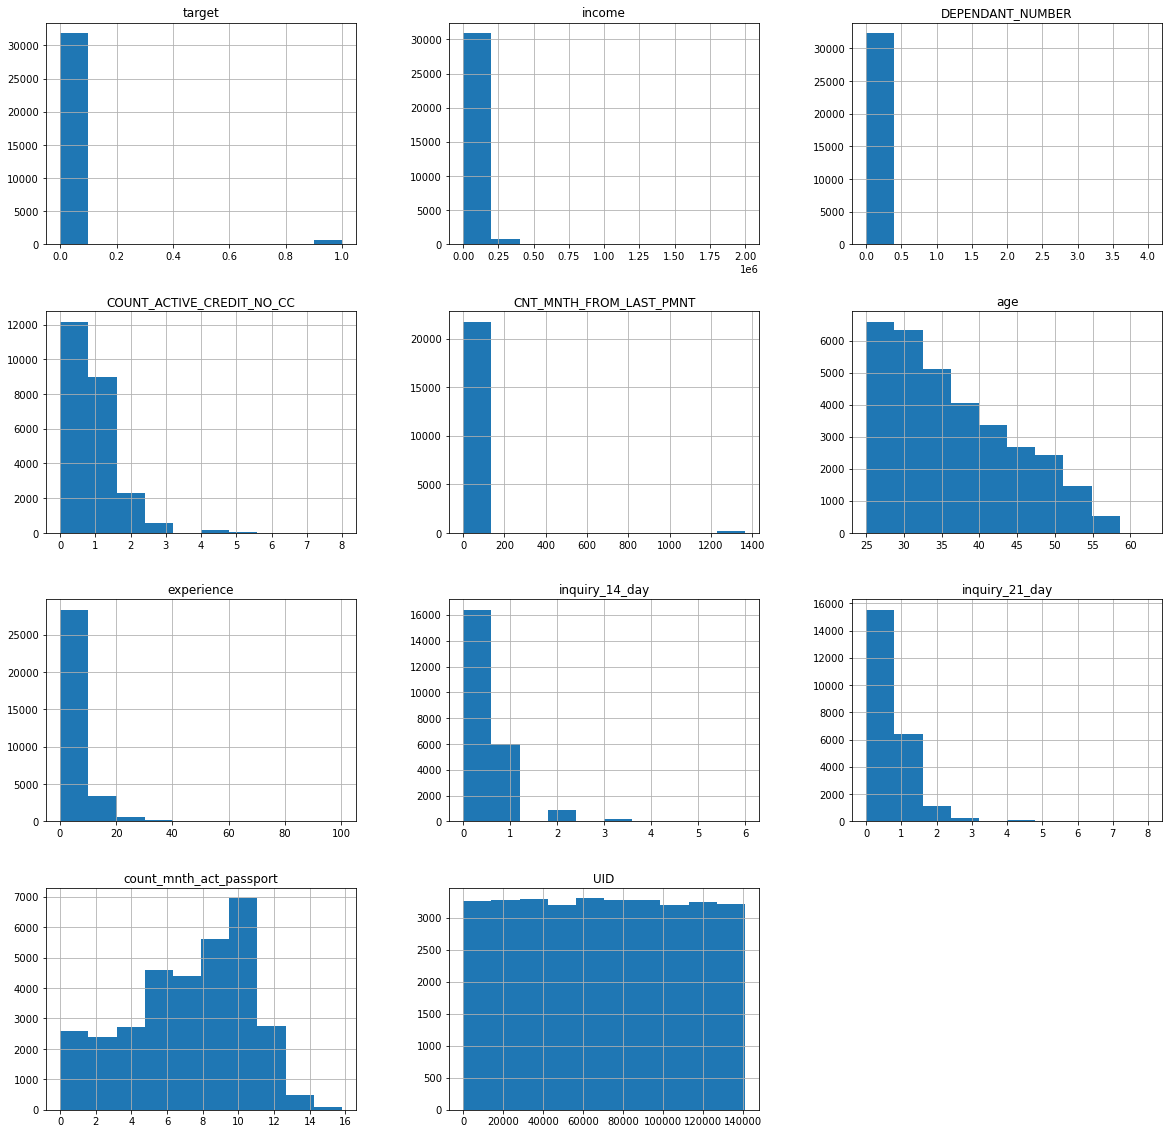

In [867]:
accept.hist(figsize = (20, 20))

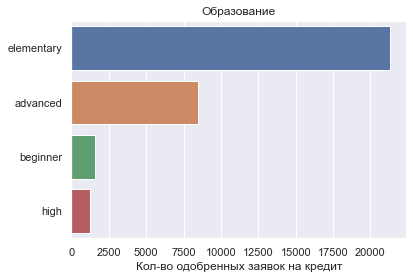

In [869]:
sns.set()

fig, ax = plt.subplots()
ax = sns.countplot(y='EDUCATION_', data=accept)
ax.set_title('Образование')
ax.set_ylabel('')

ax.set(xlabel='Кол-во одобренных заявок на кредит')


plt.show()

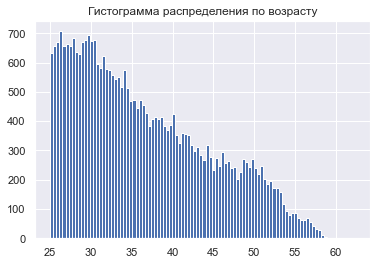

In [870]:
plt.hist(accept['age'],bins=100)
plt.title('Гистограмма распределения по возрасту')
plt.show()

#### Из интересного: скорее всего, есть бизнес-правило, которое не рекомендует выдавать кредиты людям до 25 лет

#### Каких-то явных выбросов не выявлено

In [814]:
data = accept
scorecard = pd.DataFrame()

In [815]:
for col in num_cols:
    df, iv = calculate_woe_iv(data, col + '_bin', 'target')
    df['feature'] = col
    data = data.merge(df[['Value', 'WoE']], how='inner', left_on=col + '_bin', right_on='Value' )
    data = data.rename(columns={'WoE':'WoE'+'_'+col})
    data = data.drop(columns = [col, col + '_bin', 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])

for col in cat_cols:
    df, iv = calculate_woe_iv(data, col, 'target')
    df['feature'] = col
    data = data.merge(df[['Value', 'WoE']], how='inner', left_on=col, right_on='Value' )
    data = data.rename(columns={'WoE':'WoE'+'_'+col})
    data = data.drop(columns = [col, 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])

### А вот и скоркард (заготовочка)

In [816]:
scorecard

,feature,Value,WoE
0,income,"(51627.5, 70000.0]",-0.119129
1,income,"(104400.0, 2000095.0]",0.245396
2,income,"(20212.25, 27000.0]",0.200102
3,income,"(34000.0, 41607.0]",-0.099357
4,income,"(-0.001, 20212.25]",0.428562
...,...,...,...
0,CUSTOMER_CATEGORY_,0-0,-0.392699
1,CUSTOMER_CATEGORY_,Corporate,1.204266
2,CUSTOMER_CATEGORY_,VIP,0.591783
0,IS_EMPL,No,-0.438412


In [817]:
data

,target,WoE_income,WoE_DEPENDANT_NUMBER,WoE_COUNT_ACTIVE_CREDIT_NO_CC,WoE_CNT_MNTH_FROM_LAST_PMNT,WoE_age,WoE_experience,WoE_inquiry_14_day,WoE_inquiry_21_day,WoE_count_mnth_act_passport,WoE_UID,WoE_INCOME_TYPE,WoE_EDUCATION_,WoE_CUSTOMER_CATEGORY_,WoE_IS_EMPL
0,0,-0.119129,0.05758,-0.304146,-0.262583,-0.140876,-0.220864,-0.238369,-0.238369,-0.077742,0.267880,0.203988,0.137703,-0.392699,-0.438412
1,0,0.200102,0.05758,-0.304146,-0.262583,-0.140876,-0.220864,-0.238369,-0.238369,-0.077742,0.267880,0.203988,0.137703,-0.392699,-0.438412
2,0,-0.119129,0.05758,-0.304146,-0.262583,-0.109661,-0.220864,-0.238369,-0.238369,-0.077742,0.267880,0.203988,0.137703,-0.392699,-0.438412
3,0,-0.144397,0.05758,-0.304146,-0.262583,-0.109661,-0.220864,-0.238369,-0.238369,-0.077742,0.267880,0.203988,0.137703,-0.392699,-0.438412
4,0,0.245396,0.05758,-0.304146,-0.262583,0.037249,-0.220864,-0.238369,-0.238369,-0.077742,0.267880,0.203988,0.137703,-0.392699,-0.438412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32549,0,0.245396,0.05758,0.253821,-0.262583,0.152333,-0.089834,0.204126,0.257630,0.035993,-0.319627,-0.085956,0.151961,0.591783,1.739396
32550,0,0.245396,0.05758,0.253821,-0.101551,0.209143,0.138085,0.204126,0.257630,0.195656,-0.319627,-0.085956,0.151961,0.591783,1.739396
32551,0,-0.119129,0.05758,0.253821,0.754691,0.152333,0.625418,0.204126,0.257630,0.195656,0.267880,-0.085956,-0.206794,0.591783,1.739396
32552,0,0.245396,0.05758,0.253821,-0.162388,0.037249,-0.121933,0.204126,0.257630,0.193655,0.001404,-0.085956,-0.206794,0.591783,1.739396


In [818]:
y = data['target']
X = data.drop('target', axis=1)
X.drop('WoE_age', axis=1, inplace=True)
X.drop('WoE_DEPENDANT_NUMBER', axis=1, inplace=True)
X.drop('WoE_INCOME_TYPE', axis=1, inplace=True)
#Низкий IV

In [819]:
corr_matrix = X.corr()

<AxesSubplot:>

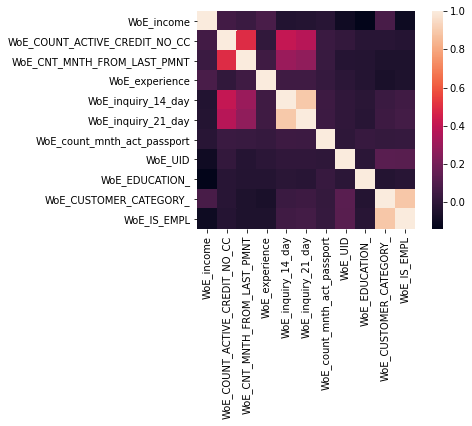

In [820]:
sns.heatmap(corr_matrix, square=True)

Очевидна корреляция между признаками WoE_inquiry_14_day и WoE_inquiry_21_day (и по определению признаков, и по диаграмме). Чтобы она нам не мешала в дальнейшем - уберем один из этих признаков. Как и один из коррелирующих признаков WoE_CUSTOMER_CATEGORY_ и WoE_IS_EMPL, у которых связь не так логична, но всё же: ВИП-клиенты вряд ли безработные:)

In [821]:
X.drop('WoE_inquiry_14_day', axis=1, inplace=True)     #сильная корреляция с другим признаком и IV ниже чем у другого признака
X.drop('WoE_CUSTOMER_CATEGORY_', axis=1, inplace=True) #аналогично

### Log-reg WoE

In [822]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

reg = LogisticRegression()
params = {'C': np.arange(0.01,3,0.05),
          'penalty':["l1","l2"]}
grid = GridSearchCV(reg, params, cv=5, scoring='f1')
grid.fit(X_train, y_train)
print("Best C = %.4f" % grid.best_params_['C'])
print("Best penalty =", grid.best_params_['penalty'])

Best C = 0.0100
Best penalty = l2


In [823]:
reg = LogisticRegression(C=0.01, penalty="l2")
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('F1-score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(reg.score(X_test, y_test)))

F1-score: 0.13
Accuracy of logistic regression classifier on test set: 0.98


In [824]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, reg.predict_proba(X_test)[:,1])
print('GINI: {:.2f}'.format(2 * auc(fpr, tpr) - 1))

GINI: 0.56


##### Слабоватый F-1 score (как бы не обучался именно на f-1, видимо несбалансированность выборки всё-таки перетягивает многие значения и предсказания => с высокой точностью у нас малый f-1), точность хорошая (естественно, благодаря несбалансированности выборки), GINI приемлемый, но надо лучше

### Reject Inference

In [825]:
reject = pd.read_csv("14_reject.csv")

In [826]:
print('Доля отказанных заявок: {:.2f}'.format(reject.shape[0] / (accept.shape[0] + reject.shape[0])))

Доля отказанных заявок: 0.25


In [827]:
reject['CNT_MNTH_FROM_LAST_PMNT'] = reject[['CNT_MNTH_FROM_LAST_PMNT']].apply(lambda x: x[0] if x[0] >= 0 else np.NaN, axis=1)
for col in num_cols:
    reject[col] = reject[col].fillna(-999)
reject['CUSTOMER_CATEGORY_'].fillna('0-0', inplace=True)

In [828]:
#преобразуем категориальные признаки в числовые с использованием имеющихся из accept значений
reject['IS_EMPL'].replace(0, -0.438412, inplace=True)
reject['IS_EMPL'].replace(1, 1.739396, inplace=True)
reject['INCOME_TYPE'].replace('2NDFL', 0.203988, inplace=True)
reject['INCOME_TYPE'].replace('OTHER', -0.085956, inplace=True)
reject['EDUCATION_'].replace('elementary', 0.137703, inplace=True)
reject['EDUCATION_'].replace('advanced', -0.206794, inplace=True)
reject['EDUCATION_'].replace('beginner', 0.151961, inplace=True)
reject['EDUCATION_'].replace('high', -0.627815, inplace=True)
reject['CUSTOMER_CATEGORY_'].replace('Corporate', 1.204266, inplace=True)
reject['CUSTOMER_CATEGORY_'].replace('0-0', -0.392699, inplace=True)
reject['CUSTOMER_CATEGORY_'].replace('VIP', 0.591783, inplace=True)

In [829]:
reject

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
0,0.203988,0.137703,-0.392699,26106.0,0.0,-0.438412,0.0,1.666801,24.353193,3.284153,1.0,1.0,4.268261,12
1,0.203988,0.137703,-0.392699,30276.0,0.0,-0.438412,1.0,0.660461,23.534494,3.581069,0.0,0.0,1.411206,27
2,0.203988,-0.206794,-0.392699,23147.0,0.0,-0.438412,0.0,4.342025,24.580021,0.645774,0.0,1.0,4.544405,33
3,0.203988,-0.206794,-0.392699,33116.0,0.0,-0.438412,0.0,0.758714,23.284153,0.901130,0.0,0.0,3.183060,41
4,0.203988,0.137703,-0.392699,45972.0,0.0,-0.438412,-999.0,-999.000000,24.528535,1.405247,-999.0,-999.0,3.581967,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,0.203988,-0.206794,-0.392699,24311.0,0.0,-0.438412,-999.0,-999.000000,23.456284,1.188060,-999.0,-999.0,3.401639,140863
10689,-0.085956,0.137703,-0.392699,21400.0,0.0,-0.438412,0.0,1.271550,24.040984,0.994303,0.0,0.0,2.739509,140864
10690,-0.085956,0.137703,1.204266,22532.0,0.0,1.739396,1.0,0.601299,24.442623,0.568531,1.0,1.0,4.377049,140869
10691,-0.085956,0.137703,-0.392699,21750.0,0.0,-0.438412,-999.0,-999.000000,23.218579,0.742039,-999.0,-999.0,3.002313,140885


Так как я работаю только с выборкой reject, о которой ничего не известно в плане target'а (не можем преобразовывать и обрабатывать данные), то я разобью на бины и присвою те же WoE значения, что и у аналогичных значений в выборке accept. Таким образом, я привожу выборку к тому виду, в котором у меня уже существуют заявки accept

In [830]:
for i in range(reject.shape[0]):
    if reject.loc[i, 'UID'] <= 140904.0 and reject.loc[i, 'UID'] > 123402.875:
        reject.loc[i, 'UID'] = -0.319627
    elif reject.loc[i, 'UID'] <= 17604.125 and reject.loc[i, 'UID'] > 9.999:
        reject.loc[i, 'UID'] = 0.267880
    elif reject.loc[i, 'UID'] <= 123402.875 and reject.loc[i, 'UID'] > 105469.0:
        reject.loc[i, 'UID'] = -0.021826
    elif reject.loc[i, 'UID'] <= 105469.0 and reject.loc[i, 'UID'] > 87570.125:
        reject.loc[i, 'UID'] = 0.166507
    elif reject.loc[i, 'UID'] <= 87570.125 and reject.loc[i, 'UID'] > 70207.0:
        reject.loc[i, 'UID'] = -0.066795
    elif reject.loc[i, 'UID'] <= 70207.0 and reject.loc[i, 'UID'] > 52766.375:
        reject.loc[i, 'UID'] = 0.282918
    elif reject.loc[i, 'UID'] <= 52766.375 and reject.loc[i, 'UID'] > 35223.75:
        reject.loc[i, 'UID'] = -0.161434
    elif reject.loc[i, 'UID'] <= 35223.75 and reject.loc[i, 'UID'] > 17604.125:
        reject.loc[i, 'UID'] = 0.001404

In [831]:
for i in range(reject.shape[0]):
    if reject.loc[i, 'count_mnth_act_passport'] <= 10.858 and reject.loc[i, 'count_mnth_act_passport'] > 9.918:
        reject.loc[i, 'count_mnth_act_passport'] = 0.195656
    elif reject.loc[i, 'count_mnth_act_passport'] <= 7.762 and reject.loc[i, 'count_mnth_act_passport'] > 6.304:
        reject.loc[i, 'count_mnth_act_passport'] = 0.126766
    elif reject.loc[i, 'count_mnth_act_passport'] <= 2.548 and reject.loc[i, 'count_mnth_act_passport'] > 0.0017299999999999998:
        reject.loc[i, 'count_mnth_act_passport'] = -0.378558
    elif reject.loc[i, 'count_mnth_act_passport'] <= 9.918 and reject.loc[i, 'count_mnth_act_passport'] > 9.041:
        reject.loc[i, 'count_mnth_act_passport'] = 0.252565
    elif reject.loc[i, 'count_mnth_act_passport'] <= 6.304 and reject.loc[i, 'count_mnth_act_passport'] > 4.952:
        reject.loc[i, 'count_mnth_act_passport'] = -0.077742
    elif reject.loc[i, 'count_mnth_act_passport'] <= 4.952 and reject.loc[i, 'count_mnth_act_passport'] > 2.548:
        reject.loc[i, 'count_mnth_act_passport'] = -0.181609
    elif reject.loc[i, 'count_mnth_act_passport'] <= 9.041 and reject.loc[i, 'count_mnth_act_passport'] > 7.762:
        reject.loc[i, 'count_mnth_act_passport'] = 0.193655
    elif reject.loc[i, 'count_mnth_act_passport'] <= 15.805 and reject.loc[i, 'count_mnth_act_passport'] > 10.858:
        reject.loc[i, 'count_mnth_act_passport'] = 0.035993
    else:
        reject.loc[i, 'count_mnth_act_passport'] = 0.000000

In [832]:
for i in range(reject.shape[0]):
    if reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] <= 0.54 and reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] > 0.381:
        reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] = -0.052437
    elif reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] <= 1365.277 and reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] > 15.049:
        reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] = 0.754691
    elif reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] <= 15.049 and reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] > 3.736:
        reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] = 0.719232
    elif reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] <= 1.215 and reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] > 0.952:
        reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] = -0.162388
    elif reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] <= 0.381 and reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] > -0.001:
        reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] = 0.273968
    elif reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] <= 3.736 and reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] > 1.215:
        reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] = 0.343700
    elif reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] <= 0.952 and reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] > 0.54:
        reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] = -0.101551
    else:
        reject.loc[i, 'CNT_MNTH_FROM_LAST_PMNT'] = -0.262583

In [833]:
for i in range(reject.shape[0]):
    if reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] <= 1.0 and reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] > -0.001:
        reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] = 0.253821
    elif reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] <= 2.0 and reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] > 1.0:
        reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] = -0.343890
    elif reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] <= 8.0 and reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] > 2.0:
        reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] = -0.764564
    else:
        reject.loc[i, 'COUNT_ACTIVE_CREDIT_NO_CC'] = -0.304146

In [834]:
for i in range(reject.shape[0]):
    if reject.loc[i, 'experience'] <= 3.282 and reject.loc[i, 'experience'] > 2.115:
        reject.loc[i, 'experience'] = -0.220864
    elif reject.loc[i, 'experience'] <= 100.355 and reject.loc[i, 'experience'] > 10.232:
        reject.loc[i, 'experience'] = 0.138085
    elif reject.loc[i, 'experience'] <= 6.548 and reject.loc[i, 'experience'] > 4.756:
        reject.loc[i, 'experience'] = -0.089834
    elif reject.loc[i, 'experience'] <= 0.577 and reject.loc[i, 'experience'] > 0.045399999999999996:
        reject.loc[i, 'experience'] = 0.895279
    elif reject.loc[i, 'experience'] <= 2.115 and reject.loc[i, 'experience'] > 1.232:
        reject.loc[i, 'experience'] = -0.121933
    elif reject.loc[i, 'experience'] <= 10.232 and reject.loc[i, 'experience'] > 6.548:
        reject.loc[i, 'experience'] = 0.625418
    elif reject.loc[i, 'experience'] <= 1.232 and reject.loc[i, 'experience'] > 0.577:
        reject.loc[i, 'experience'] = -0.286195
    elif reject.loc[i, 'experience'] <= 4.756 and reject.loc[i, 'experience'] > 3.282:
        reject.loc[i, 'experience'] = 0.085035
    else:
        reject.loc[i, 'experience'] = -5.950459

In [835]:
for i in range(reject.shape[0]):
    if reject.loc[i, 'inquiry_21_day'] <= 8.0 and reject.loc[i, 'inquiry_21_day'] > 1:
        reject.loc[i, 'inquiry_21_day'] = -1.023104
    elif reject.loc[i, 'inquiry_21_day'] <= 1.0 and reject.loc[i, 'inquiry_21_day'] > -0.001:
        reject.loc[i, 'inquiry_21_day'] = 0.257630
    else:
        reject.loc[i, 'inquiry_21_day'] = -0.238369

In [836]:
for i in range(reject.shape[0]):
    if reject.loc[i, 'income'] <= 20212.25 and reject.loc[i, 'income'] > -0.001:
        reject.loc[i, 'income'] = 0.428562
    elif reject.loc[i, 'income'] <= 70000 and reject.loc[i, 'income'] > 51627.5:
        reject.loc[i, 'income'] = -0.119129
    elif reject.loc[i, 'income'] <= 27000 and reject.loc[i, 'income'] > 20212.25:
        reject.loc[i, 'income'] = 0.200102
    elif reject.loc[i, 'income'] <= 51627.5 and reject.loc[i, 'income'] > 41607.0:
        reject.loc[i, 'income'] = -0.120925
    elif reject.loc[i, 'income'] <= 41607.0 and reject.loc[i, 'income'] > 34000.0:
        reject.loc[i, 'income'] = -0.099357
    elif reject.loc[i, 'income'] <= 2000095.0 and reject.loc[i, 'income'] > 104400.0:
        reject.loc[i, 'income'] = 0.245396
    elif reject.loc[i, 'income'] <= 34000 and reject.loc[i, 'income'] > 27000.0:
        reject.loc[i, 'income'] = 0.233832
    elif reject.loc[i, 'income'] <= 104400.0 and reject.loc[i, 'income'] > 70000.0:
        reject.loc[i, 'income'] = -0.144397
    else:
        reject.loc[i, 'income'] = -1.337320

In [837]:
X_1 = reject

In [838]:
# Выбрасываю все те признаки, которых нет в предыдущей модели
X_1.drop('age', axis=1, inplace=True)
X_1.drop('DEPENDANT_NUMBER', axis=1, inplace=True)
X_1.drop('INCOME_TYPE', axis=1, inplace=True)
X_1.drop('inquiry_14_day', axis=1, inplace=True)
X_1.drop('CUSTOMER_CATEGORY_', axis=1, inplace=True)

In [839]:
# И полностью привожу данные к виду одобренной выборки (порядок столбцов и их названия)
X_1 = X_1.reindex(columns=['income', 'COUNT_ACTIVE_CREDIT_NO_CC', 'CNT_MNTH_FROM_LAST_PMNT', 'experience', 'inquiry_21_day', 'count_mnth_act_passport', 'UID', 'EDUCATION_', 'IS_EMPL'])
X_1

,income,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,experience,inquiry_21_day,count_mnth_act_passport,UID,EDUCATION_,IS_EMPL
0,0.200102,0.253821,0.343700,0.085035,0.257630,-0.181609,0.267880,0.137703,-0.438412
1,0.233832,0.253821,-0.101551,0.085035,0.257630,-0.378558,0.267880,0.137703,-0.438412
2,0.200102,0.253821,0.719232,-0.286195,0.257630,-0.181609,0.267880,-0.206794,-0.438412
3,0.233832,0.253821,-0.101551,-0.286195,0.257630,-0.181609,0.267880,-0.206794,-0.438412
4,-0.120925,-0.304146,-0.262583,-0.121933,-0.238369,-0.181609,0.267880,0.137703,-0.438412
...,...,...,...,...,...,...,...,...,...
10688,0.200102,-0.304146,-0.262583,-0.286195,-0.238369,-0.181609,-0.319627,-0.206794,-0.438412
10689,0.200102,0.253821,0.343700,-0.286195,0.257630,-0.181609,-0.319627,0.137703,-0.438412
10690,0.200102,0.253821,-0.101551,0.895279,0.257630,-0.181609,-0.319627,0.137703,1.739396
10691,0.200102,-0.304146,-0.262583,-0.286195,-0.238369,-0.181609,-0.319627,0.137703,-0.438412


In [842]:
X_1.rename(columns={'income': 'WoE_income',
                    'COUNT_ACTIVE_CREDIT_NO_CC': 'WoE_COUNT_ACTIVE_CREDIT_NO_CC',
                    'CNT_MNTH_FROM_LAST_PMNT': 'WoE_CNT_MNTH_FROM_LAST_PMNT',
                    'experience': 'WoE_experience',
                    'inquiry_21_day': 'WoE_inquiry_21_day',
                    'count_mnth_act_passport': 'WoE_count_mnth_act_passport',
                    'UID': 'WoE_UID',
                    'EDUCATION_': 'WoE_EDUCATION_',
                    'IS_EMPL': 'WoE_IS_EMPL'}, inplace=True)

In [843]:
X_1

,WoE_income,WoE_COUNT_ACTIVE_CREDIT_NO_CC,WoE_CNT_MNTH_FROM_LAST_PMNT,WoE_experience,WoE_inquiry_21_day,WoE_count_mnth_act_passport,WoE_UID,WoE_EDUCATION_,WoE_IS_EMPL
0,0.200102,0.253821,0.343700,0.085035,0.257630,-0.181609,0.267880,0.137703,-0.438412
1,0.233832,0.253821,-0.101551,0.085035,0.257630,-0.378558,0.267880,0.137703,-0.438412
2,0.200102,0.253821,0.719232,-0.286195,0.257630,-0.181609,0.267880,-0.206794,-0.438412
3,0.233832,0.253821,-0.101551,-0.286195,0.257630,-0.181609,0.267880,-0.206794,-0.438412
4,-0.120925,-0.304146,-0.262583,-0.121933,-0.238369,-0.181609,0.267880,0.137703,-0.438412
...,...,...,...,...,...,...,...,...,...
10688,0.200102,-0.304146,-0.262583,-0.286195,-0.238369,-0.181609,-0.319627,-0.206794,-0.438412
10689,0.200102,0.253821,0.343700,-0.286195,0.257630,-0.181609,-0.319627,0.137703,-0.438412
10690,0.200102,0.253821,-0.101551,0.895279,0.257630,-0.181609,-0.319627,0.137703,1.739396
10691,0.200102,-0.304146,-0.262583,-0.286195,-0.238369,-0.181609,-0.319627,0.137703,-0.438412


In [844]:
# Обученную модель применяю к новым данным
X_2 = pd.DataFrame(reg.predict_proba(X_1)[:,1])

In [845]:
pd.DataFrame(reg.predict_proba(X_test)[:,1]).describe()

,0
count,6511.000000
mean,0.021316
std,0.030895
min,0.002501
25%,0.007451
50%,0.018800
75%,0.029838
max,0.773488


Пусть из reject мы будем принимать только те заявки, которые соответствуют вероятности дефолта меньше 90% квантиля из accept.
Доля 1 в выборке accept примерно 2%, к которым мы и должны стремиться для сохранения распределения, но т.к. здесь мы работаем с отказанными заявками, распределение я сделаю всё-таки чуть более смещенное в сторону чуть большей доли дефолта

In [861]:
X_3 = pd.DataFrame()
for i in range(X_2.shape[0]):
    if X_2.loc[i, 0] < 0.048:
        X_3.loc[i, 0] = 0
    else:
        X_3.loc[i, 0] = 1

In [862]:
#и теперь сделаем из не самых ужасных отказанных заявок ещё рандомных принятых
i = 0
while i <= 7000:
    a = random.randint(0, X_2.shape[0]-1)
    if X_2.loc[a, 0] < 0.08:
        X_3.loc[a, 0] = 0
    i += 1

In [863]:
X_3.value_counts()

0.0    10401
1.0      292
dtype: int64

### Готово, чуть более двух с половиной процентов

### Теперь готовимся к общей регрессии

In [864]:
X = pd.concat([X, X_1], ignore_index=True)
X

,WoE_income,WoE_COUNT_ACTIVE_CREDIT_NO_CC,WoE_CNT_MNTH_FROM_LAST_PMNT,WoE_experience,WoE_inquiry_21_day,WoE_count_mnth_act_passport,WoE_UID,WoE_EDUCATION_,WoE_IS_EMPL
0,-0.119129,-0.304146,-0.262583,-0.220864,-0.238369,-0.077742,0.267880,0.137703,-0.438412
1,0.200102,-0.304146,-0.262583,-0.220864,-0.238369,-0.077742,0.267880,0.137703,-0.438412
2,-0.119129,-0.304146,-0.262583,-0.220864,-0.238369,-0.077742,0.267880,0.137703,-0.438412
3,-0.144397,-0.304146,-0.262583,-0.220864,-0.238369,-0.077742,0.267880,0.137703,-0.438412
4,0.245396,-0.304146,-0.262583,-0.220864,-0.238369,-0.077742,0.267880,0.137703,-0.438412
...,...,...,...,...,...,...,...,...,...
43242,0.200102,-0.304146,-0.262583,-0.286195,-0.238369,-0.181609,-0.319627,-0.206794,-0.438412
43243,0.200102,0.253821,0.343700,-0.286195,0.257630,-0.181609,-0.319627,0.137703,-0.438412
43244,0.200102,0.253821,-0.101551,0.895279,0.257630,-0.181609,-0.319627,0.137703,1.739396
43245,0.200102,-0.304146,-0.262583,-0.286195,-0.238369,-0.181609,-0.319627,0.137703,-0.438412


In [865]:
y = pd.concat([y, X_3], ignore_index=True)
y

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
43242,1.0
43243,0.0
43244,0.0
43245,0.0


In [866]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

reg = LogisticRegression(C=0.01, penalty="l2")
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, reg.predict_proba(X_test)[:,1])

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(reg.score(X_test, y_test)))
print('GINI: {:.2f}'.format(2 * auc(fpr, tpr) - 1))
print('F1-score: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy of logistic regression classifier on test set: 0.98
GINI: 0.65
F1-score: 0.12


## Выводы

Точность прогноза с точностью до сотых не изменилась. F-1 score всё-таки колеблется вокруг чисел 0.12-0.13, и тоже примерно совпадает с изначальной моделью. А вот индекс GINI заметно вырос (был 0.56(+-) стал 0.65(+-)). То есть, мы стали ближе по распределению скоринга к идеальной модели.
В целом лучше использовать вторую модель. Во-первых, у нас банально больше данных для обучения (хоть и приходится несколько играть с прогнозом дефолта в отказанных заявках). Во-вторых, у нас достаточно большая доля отказанных заявок (четверть всех заявок), поэтому выборка только по одобренным заявкам может быть смещенной. Это является основной причиной использования в данном случае Reject Inference. F-1 score не изменился, но мы стали работать с большим кол-вом заявок => на самом деле, он должен вырасти, т.к. в reject у нас попали заявки, некоторые из которых выглядят с точки зрения обученной модели очень неплохо, а это значит, что ранее они у нас в рассмотрение не входили (а потому по идее уменьшали recall и соответственно f1-score). 
Кроме того, рисков дополнительных мы в этом случае не несём, т.к. accuracy и F-1 score всё же остаются на том же уровне. А наше приближение к идеальной модели позволяет нам оптимальнее реагировать на новую поступающую информацию: например, пришла инфромация о клиенте, что у него задержка по зарплате => predict_proba увеличивается, но наша модель позволит нам лучше оценить новую ситуацию, в которой оказался клиент, подобрать лучшее предложение при всех известных условиях и в целом действовать оптимальнее с неизменным риском дефолта (т.к. напоминаю, новая модель по точности прогноза соответствует изначальной на выборке accept).

Так и не понял, что такое UID